# Commodity price forecasting using CNN-GRU

In [1]:
import pandas as pd
import numpy as np
import os
import time

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# preprocessing methods
from sklearn.preprocessing import StandardScaler

# accuracy measures and data spliting
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split

# deep learning libraries
from keras.models import Input, Model
from keras.models import Sequential
from keras.layers import SimpleRNN, LSTM, Dense, GRU
from keras.layers import Conv1D, MaxPooling1D
from keras.layers import Flatten
from keras import layers
from keras import losses
from keras import optimizers
from keras import metrics
from keras import callbacks
from keras import initializers

Using TensorFlow backend.


In [2]:
plt.style.use('seaborn')
plt.rcParams['figure.figsize'] = 15, 7

## 1. Data import and basic analysis

In [3]:
DATADIR = 'data/'
MODELDIR = '../checkpoints/commodity/nn/'

path = os.path.join(DATADIR, 'gold-silver.csv')
data = pd.read_csv(path, header=0, index_col=[0], infer_datetime_format=True, sep=';')

data.head()

,gold,silver
Date,,
1993/11/01,369.25,4.25
1993/12/01,376.30,4.62
1994/01/01,394.00,5.24
1994/02/01,384.50,5.31
1994/03/01,378.75,5.32


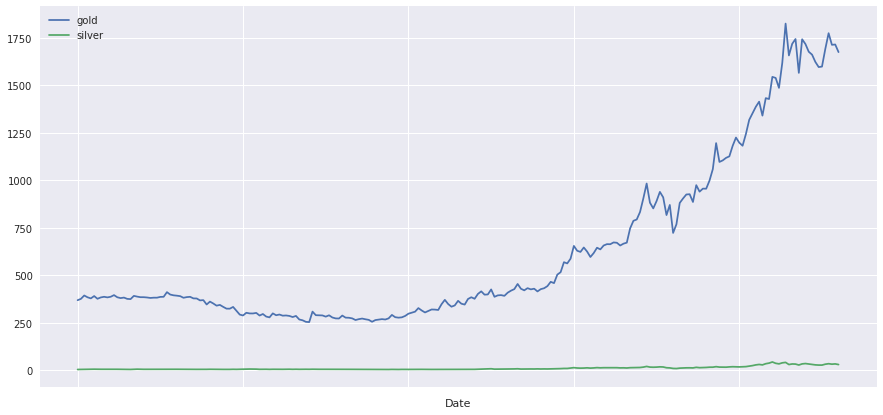

In [4]:
data[['gold', 'silver']].plot();

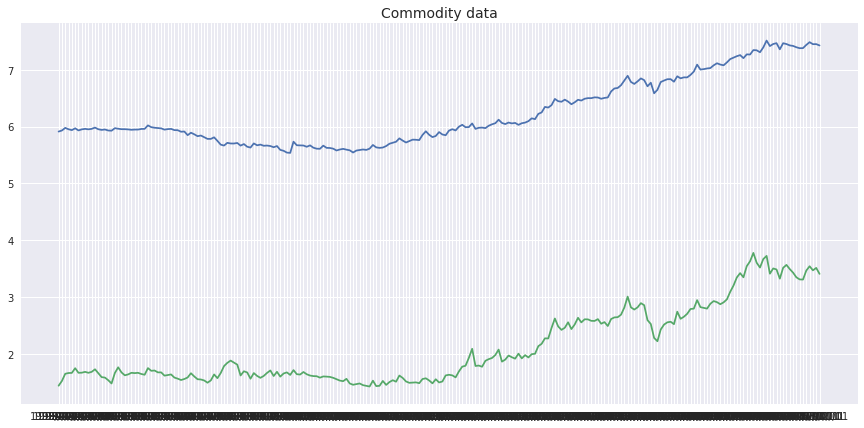

In [5]:
plt.plot(np.log(data.gold), label='log(gold)')
plt.plot(np.log(data.silver), label='log(silver)')
plt.title('Commodity data', fontsize='14')
plt.show()

## 2. Data preparation

In [6]:
# function to prepare x and y variable
# for the univariate series
def prepare_data(df, steps=1):
    temp = df.shift(-steps).copy()
    y = temp[:-steps].copy()
    X = df[:-steps].copy()
    return X, y

In [7]:
gold_X, gold_y = prepare_data(np.log(data[['gold']]), steps=1)
silver_X, silver_y = prepare_data(np.log(data[['silver']]), steps=1)

len(gold_X), len(gold_y), len(silver_X), len(silver_y)

(230, 230, 230, 230)

In [8]:
X = pd.concat([gold_X, silver_X], axis=1)
y = pd.concat([gold_y, silver_y], axis=1)

In [9]:
X.head()

,gold,silver
Date,,
1993/11/01,5.911474,1.446919
1993/12/01,5.930387,1.530395
1994/01/01,5.976351,1.656321
1994/02/01,5.951944,1.669592
1994/03/01,5.936876,1.671473


In [10]:
y.head()

,gold,silver
Date,,
1993/11/01,5.930387,1.530395
1993/12/01,5.976351,1.656321
1994/01/01,5.951944,1.669592
1994/02/01,5.936876,1.671473
1994/03/01,5.968708,1.754404


In [11]:
seed = 42
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05, 
                                                    random_state=seed, shuffle=False)

print('Training and test data shape:')
X_train.shape, y_train.shape, X_test.shape, y_test.shape

Training and test data shape:


((218, 2), (218, 2), (12, 2), (12, 2))

In [12]:
timesteps = 1
features = X_train.shape[1]
xavier = initializers.glorot_normal()

X_train = np.reshape(X_train.values, (X_train.shape[0], timesteps, features))
X_test = np.reshape(X_test.values, (X_test.shape[0], timesteps, features))

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((218, 1, 2), (12, 1, 2), (218, 2), (12, 2))

## 3. Model building

In [13]:
def model_evaluation(y_train, y_test, y_train_pred, y_test_pred):
    
    y_train_inv, y_test_inv = np.exp(y_train), np.exp(y_test)
    y_train_pred_inv, y_test_pred_inv = np.exp(y_train_pred), np.exp(y_test_pred)
    
    # MAE and NRMSE calculation for gold
    y_train_gold = y_train_inv.values[:, 0]
    y_train_pred_gold = y_train_pred_inv[:, 0]  
    y_test_gold = y_test_inv.values[:, 0]
    y_test_pred_gold = y_test_pred_inv[:, 0]
    
    train_rmse_g = np.sqrt(mean_squared_error(y_train_gold, y_train_pred_gold))
    train_mae_g = np.round(mean_absolute_error(y_train_gold, y_train_pred_gold), 3)
    train_nrmse_g = np.round(train_rmse_g/np.std(y_train_gold), 3)

    test_rmse_g = np.sqrt(mean_squared_error(y_test_gold, y_test_pred_gold))
    test_mae_g = np.round(mean_absolute_error(y_test_gold, y_test_pred_gold), 3)
    test_nrmse_g = np.round(test_rmse_g/np.std(y_test_gold), 3)
    
    print('Training and test result for gold:')
    print(f'Training MAE: {train_mae_g}')
    print(f'Trainig NRMSE: {train_nrmse_g}')
    print(f'Test MAE: {test_mae_g}')
    print(f'Test NRMSE: {test_nrmse_g}')
    print()
    
    
    # MAE and NRMSE calculation for silver
    y_train_silver = y_train_inv.values[:, 1]
    y_train_pred_silver = y_train_pred_inv[:, 1]
    y_test_silver = y_test_inv.values[:, 1]
    y_test_pred_silver = y_test_pred_inv[:, 1] 
    
    train_rmse_s = np.sqrt(mean_squared_error(y_train_silver, y_train_pred_silver))
    train_mae_s = np.round(mean_absolute_error(y_train_silver, y_train_pred_silver), 3)
    train_nrmse_s = np.round(train_rmse_s/np.std(y_train_silver), 3)

    test_rmse_s = np.sqrt(mean_squared_error(y_test_silver, y_test_pred_silver))
    test_mae_s = np.round(mean_absolute_error(y_test_silver, y_test_pred_silver), 3)
    test_nrmse_s = np.round(test_rmse_s/np.std(y_test_silver), 3)

    print('Training and test result for silver:')
    print(f'Training MAE: {train_mae_s}')
    print(f'Trainig NRMSE: {train_nrmse_s}')
    print(f'Test MAE: {test_mae_s}')
    print(f'Test NRMSE: {test_nrmse_s}')
    
    return y_train_pred_inv, y_test_pred_inv

In [14]:
def model_training(X_train, X_test, y_train, model, batch=4, name='m'):
    start = time.time()
    loss = losses.mean_squared_error
    opt = optimizers.Adam()
    metric = [metrics.mean_absolute_error]
    model.compile(loss=loss, optimizer=opt, metrics=metric)

    callbacks_list = [callbacks.ReduceLROnPlateau(monitor='loss', factor=0.2,
                              patience=5, min_lr=0.001)]

    history = model.fit(X_train, y_train, 
                        epochs=100, 
                        batch_size=batch, 
                        verbose=0,
                        shuffle=False,
                        callbacks=callbacks_list
                       )

    # save model weights and 
    if os.path.exists(MODELDIR):
        pass
    else:
        os.makedirs(MODELDIR)
    m_name = name + str('.h5')
    w_name = name + str('_w.h5')
    model.save(os.path.join(MODELDIR, m_name))
    model.save_weights(os.path.join(MODELDIR, w_name))

    # prediction
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    end = time.time()
    time_taken = np.round((end-start), 3)
    print(f'Time taken to complete the process: {time_taken} seconds')
    
    return y_train_pred, y_test_pred, history

### CNN-GRU - v1

Instructions for updating:
`NHWC` for data_format is deprecated, use `NWC` instead
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 1, 3)              21        
_________________________________________________________________
gru_1 (GRU)                  (None, 3)                 63        
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 8         
Total params: 92
Trainable params: 92
Non-trainable params: 0
_________________________________________________________________
Time taken to complete the process: 11.547 seconds
Training and test result for gold:
Training MAE: 466.572
Trainig NRMSE: 1.619
Test MAE: 1587.915
Test NRMSE: 29.878

Training and test result for silver:
Training MAE: 5.204
Trainig NRMSE: 1.028
Test MAE: 23.789
Test NRMSE: 9.18


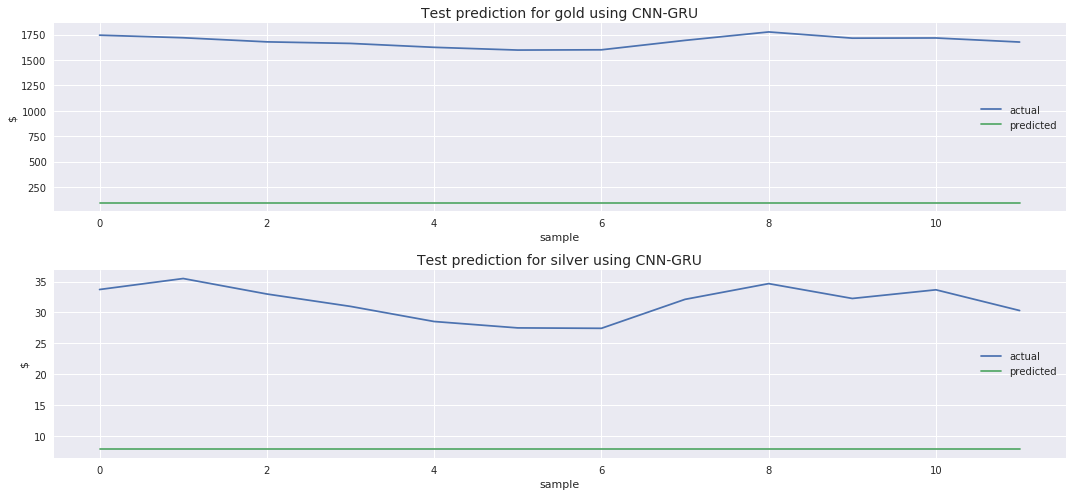

In [15]:
model = Sequential()
model.add(Conv1D(3, kernel_size=3, activation='relu', padding='same', strides=1, 
                 input_shape=(timesteps, features), kernel_initializer=xavier))

model.add(GRU(3, kernel_initializer=xavier, activation='relu'))

model.add(Dense(2, kernel_initializer=xavier))
model.summary()

# training
y_train_pred, y_test_pred, history = model_training(X_train, X_test, y_train, model, batch=4, name='cnngru-v1')

# evaluation
y_train_pred, y_test_pred = model_evaluation(y_train, y_test, y_train_pred, y_test_pred)

# plotting
plt.subplot(211)
plt.plot(np.exp(y_test.values[:, 0]), label='actual')
plt.plot(y_test_pred[:, 0], label='predicted')
plt.ylabel('$')
plt.xlabel('sample')
plt.title('Test prediction for gold using CNN-GRU', fontsize=14)
plt.legend()

plt.subplot(212)
plt.plot(np.exp(y_test.values[:, 1]), label='actual')
plt.plot(y_test_pred[:, 1], label='predicted')
plt.ylabel('$')
plt.xlabel('sample')
plt.title('Test prediction for silver using CNN-GRU', fontsize=14)
plt.legend()

plt.tight_layout()
plt.show()

### CNN-GRU- v2

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_2 (Conv1D)            (None, 1, 8)              56        
_________________________________________________________________
gru_2 (GRU)                  (None, 8)                 408       
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 18        
Total params: 482
Trainable params: 482
Non-trainable params: 0
_________________________________________________________________
Time taken to complete the process: 11.291 seconds
Training and test result for gold:
Training MAE: 83.02
Trainig NRMSE: 0.474
Test MAE: 517.525
Test NRMSE: 10.046

Training and test result for silver:
Training MAE: 3.553
Trainig NRMSE: 0.731
Test MAE: 16.564
Test NRMSE: 6.425


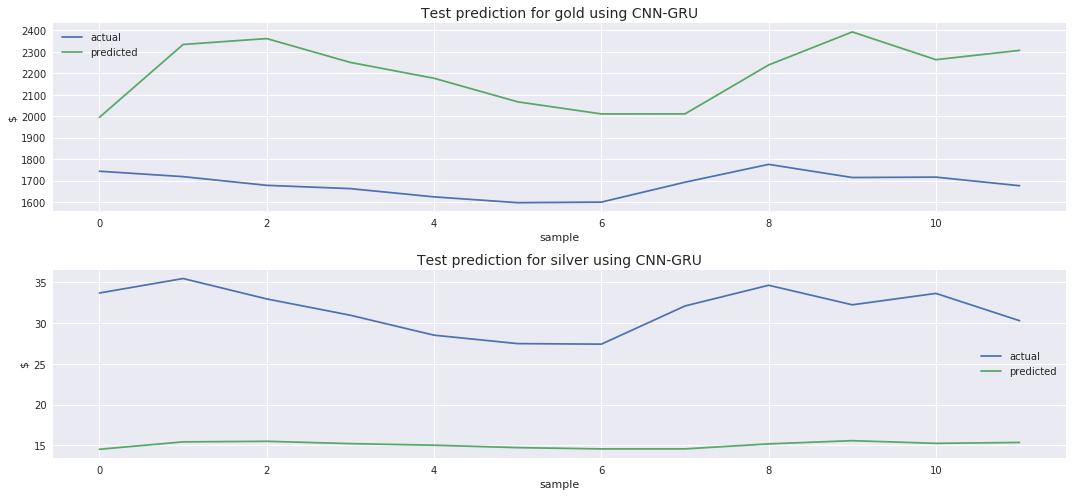

In [16]:
model = Sequential()
model.add(Conv1D(8, kernel_size=3, activation='relu', padding='same', strides=1, 
                 input_shape=(timesteps, features), kernel_initializer=xavier))

model.add(GRU(8, kernel_initializer=xavier, activation='relu'))

model.add(Dense(2, kernel_initializer=xavier))
model.summary()

# training
y_train_pred, y_test_pred, history = model_training(X_train, X_test, y_train, model, batch=4, name='cnngru-v2')

# evaluation
y_train_pred, y_test_pred = model_evaluation(y_train, y_test, y_train_pred, y_test_pred)

# plotting
plt.subplot(211)
plt.plot(np.exp(y_test.values[:, 0]), label='actual')
plt.plot(y_test_pred[:, 0], label='predicted')
plt.ylabel('$')
plt.xlabel('sample')
plt.title('Test prediction for gold using CNN-GRU', fontsize=14)
plt.legend()

plt.subplot(212)
plt.plot(np.exp(y_test.values[:, 1]), label='actual')
plt.plot(y_test_pred[:, 1], label='predicted')
plt.ylabel('$')
plt.xlabel('sample')
plt.title('Test prediction for silver using CNN-GRU', fontsize=14)
plt.legend()

plt.tight_layout()
plt.show()

### CNN-GRU - v3 (Final Model)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_3 (Conv1D)            (None, 1, 12)             84        
_________________________________________________________________
gru_3 (GRU)                  (None, 12)                900       
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 26        
Total params: 1,010
Trainable params: 1,010
Non-trainable params: 0
_________________________________________________________________
Time taken to complete the process: 12.707 seconds
Training and test result for gold:
Training MAE: 83.373
Trainig NRMSE: 0.244
Test MAE: 59.255
Test NRMSE: 1.232

Training and test result for silver:
Training MAE: 1.047
Trainig NRMSE: 0.2
Test MAE: 2.433
Test NRMSE: 1.008


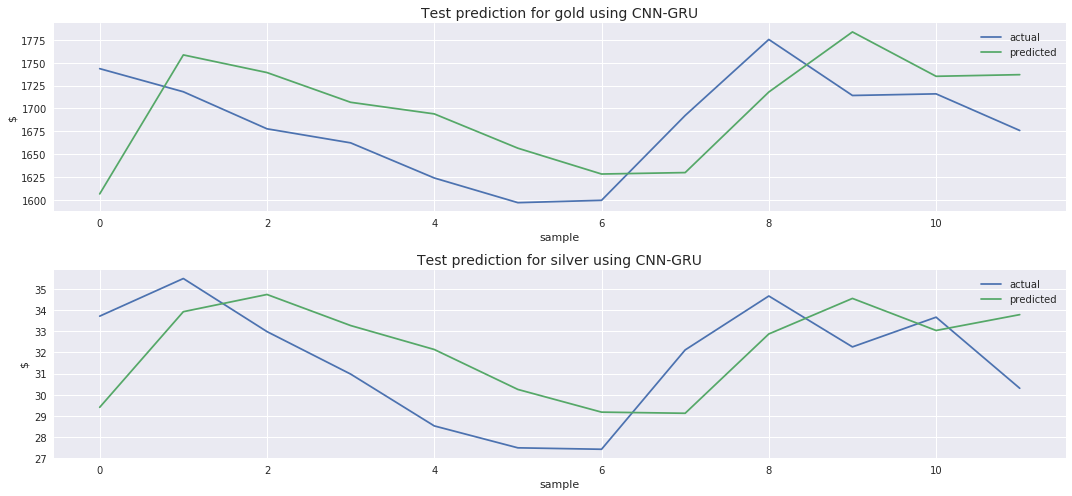

In [17]:
model = Sequential()
model.add(Conv1D(12, kernel_size=3, activation='relu', padding='same', strides=1, 
                 input_shape=(timesteps, features), kernel_initializer=xavier))

model.add(GRU(12, kernel_initializer=xavier, activation='relu'))

model.add(Dense(2, kernel_initializer=xavier))
model.summary()

# training
y_train_pred, y_test_pred, history = model_training(X_train, X_test, y_train, model, batch=4, name='cnngru-v3')

# evaluation
y_train_pred, y_test_pred = model_evaluation(y_train, y_test, y_train_pred, y_test_pred)

# plotting
plt.subplot(211)
plt.plot(np.exp(y_test.values[:, 0]), label='actual')
plt.plot(y_test_pred[:, 0], label='predicted')
plt.ylabel('$')
plt.xlabel('sample')
plt.title('Test prediction for gold using CNN-GRU', fontsize=14)
plt.legend()

plt.subplot(212)
plt.plot(np.exp(y_test.values[:, 1]), label='actual')
plt.plot(y_test_pred[:, 1], label='predicted')
plt.ylabel('$')
plt.xlabel('sample')
plt.title('Test prediction for silver using CNN-GRU', fontsize=14)
plt.legend()

plt.tight_layout()
plt.show()

### CNN-GRU - v4

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_4 (Conv1D)            (None, 1, 8)              56        
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 1, 8)              200       
_________________________________________________________________
gru_4 (GRU)                  (None, 1, 8)              408       
_________________________________________________________________
gru_5 (GRU)                  (None, 8)                 408       
_________________________________________________________________
dense_4 (Dense)              (None, 2)                 18        
Total params: 1,090
Trainable params: 1,090
Non-trainable params: 0
_________________________________________________________________
Time taken to complete the process: 16.645 seconds
Training and test result for gold:
Training MAE: 107.751
Trainig NRMSE: 0.541
Test MAE: 5

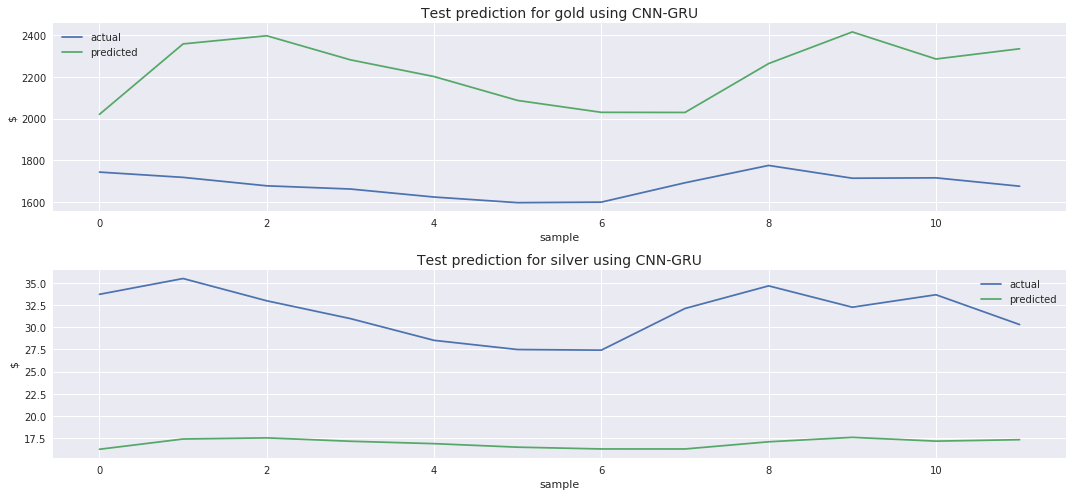

In [18]:
model = Sequential()
model.add(Conv1D(8, kernel_size=3, activation='relu', padding='same', strides=1, 
                 input_shape=(timesteps, features), kernel_initializer=xavier))
model.add(Conv1D(8, kernel_size=3, activation='relu', padding='same', strides=1, 
                 kernel_initializer=xavier))
model.add(GRU(8, kernel_initializer=xavier, activation='relu', return_sequences=True))
model.add(GRU(8, kernel_initializer=xavier, activation='relu'))
model.add(Dense(2, kernel_initializer=xavier))
model.summary()

# training
y_train_pred, y_test_pred, history = model_training(X_train, X_test, y_train, model, batch=4, name='cnngru-v4')

# evaluation
y_train_pred, y_test_pred = model_evaluation(y_train, y_test, y_train_pred, y_test_pred)

# plotting
plt.subplot(211)
plt.plot(np.exp(y_test.values[:, 0]), label='actual')
plt.plot(y_test_pred[:, 0], label='predicted')
plt.ylabel('$')
plt.xlabel('sample')
plt.title('Test prediction for gold using CNN-GRU', fontsize=14)
plt.legend()

plt.subplot(212)
plt.plot(np.exp(y_test.values[:, 1]), label='actual')
plt.plot(y_test_pred[:, 1], label='predicted')
plt.ylabel('$')
plt.xlabel('sample')
plt.title('Test prediction for silver using CNN-GRU', fontsize=14)
plt.legend()

plt.tight_layout()
plt.show()

### CNN-GRU - v5

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_6 (Conv1D)            (None, 1, 3)              21        
_________________________________________________________________
conv1d_7 (Conv1D)            (None, 1, 3)              30        
_________________________________________________________________
gru_6 (GRU)                  (None, 1, 3)              63        
_________________________________________________________________
gru_7 (GRU)                  (None, 3)                 63        
_________________________________________________________________
dense_5 (Dense)              (None, 2)                 8         
Total params: 185
Trainable params: 185
Non-trainable params: 0
_________________________________________________________________
Time taken to complete the process: 17.216 seconds
Training and test result for gold:
Training MAE: 466.591
Trainig NRMSE: 1.619
Test MAE: 1587.

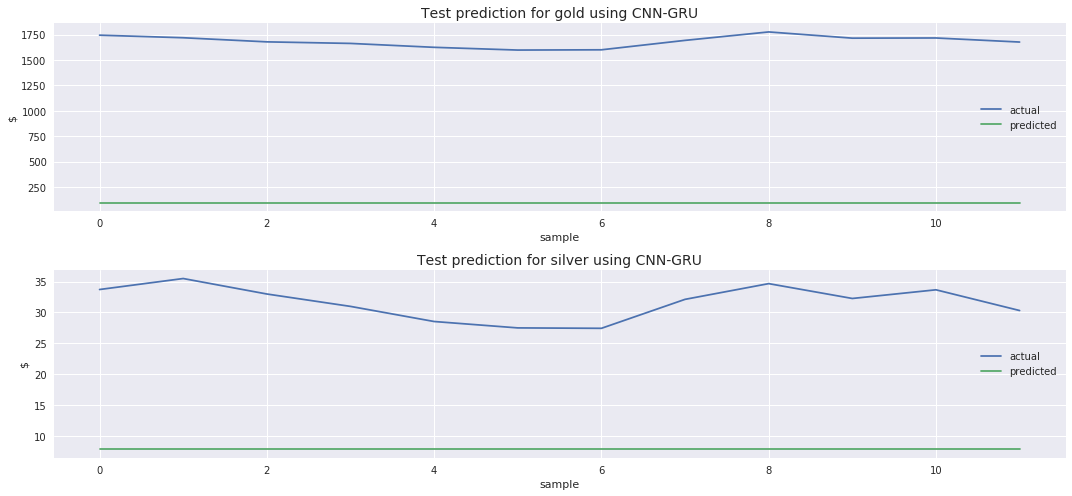

In [19]:
model = Sequential()
model.add(Conv1D(3, kernel_size=3, activation='relu', padding='same', strides=1, 
                 input_shape=(timesteps, features), kernel_initializer=xavier))
model.add(Conv1D(3, kernel_size=3, activation='relu', padding='same', strides=1, 
                 kernel_initializer=xavier))
model.add(GRU(3, kernel_initializer=xavier, activation='relu', return_sequences=True))
model.add(GRU(3, kernel_initializer=xavier, activation='relu'))
model.add(Dense(2, kernel_initializer=xavier))
model.summary()

# training
y_train_pred, y_test_pred, history = model_training(X_train, X_test, y_train, model, batch=4, name='cnngru-v5')

# evaluation
y_train_pred, y_test_pred = model_evaluation(y_train, y_test, y_train_pred, y_test_pred)

# plotting
plt.subplot(211)
plt.plot(np.exp(y_test.values[:, 0]), label='actual')
plt.plot(y_test_pred[:, 0], label='predicted')
plt.ylabel('$')
plt.xlabel('sample')
plt.title('Test prediction for gold using CNN-GRU', fontsize=14)
plt.legend()

plt.subplot(212)
plt.plot(np.exp(y_test.values[:, 1]), label='actual')
plt.plot(y_test_pred[:, 1], label='predicted')
plt.ylabel('$')
plt.xlabel('sample')
plt.title('Test prediction for silver using CNN-GRU', fontsize=14)
plt.legend()

plt.tight_layout()
plt.show()

### CNN-GRU - v6

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_8 (Conv1D)            (None, 1, 8)              56        
_________________________________________________________________
gru_8 (GRU)                  (None, 8)                 408       
_________________________________________________________________
dense_6 (Dense)              (None, 2)                 18        
Total params: 482
Trainable params: 482
Non-trainable params: 0
_________________________________________________________________
Time taken to complete the process: 41.748 seconds
Training and test result for gold:
Training MAE: 160.938
Trainig NRMSE: 0.451
Test MAE: 75.132
Test NRMSE: 1.525

Training and test result for silver:
Training MAE: 2.879
Trainig NRMSE: 0.414
Test MAE: 4.807
Test NRMSE: 2.069


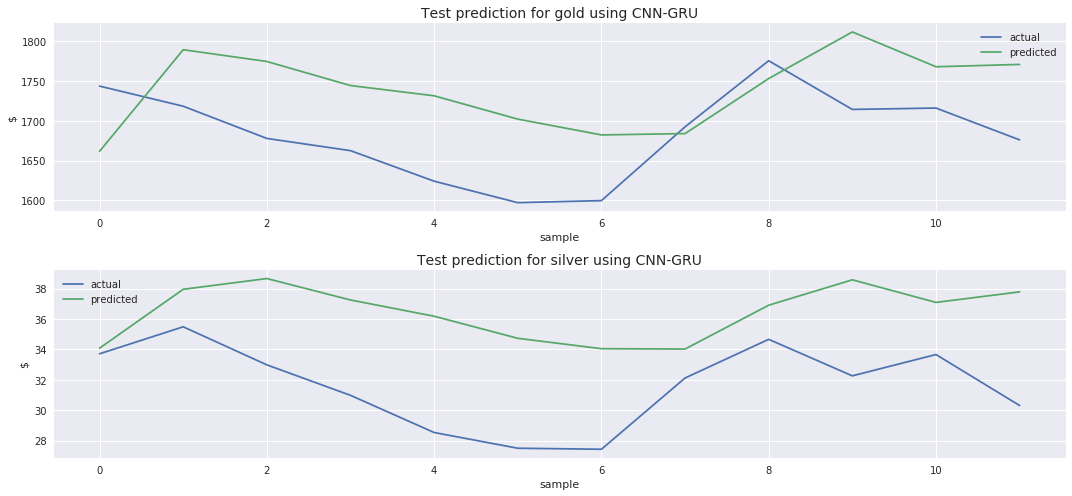

In [20]:
model = Sequential()
model.add(Conv1D(8, kernel_size=3, activation='relu', padding='same', strides=1, 
                 input_shape=(timesteps, features), kernel_initializer=xavier))

model.add(GRU(8, kernel_initializer=xavier, activation='relu'))

model.add(Dense(2, kernel_initializer=xavier))
model.summary()

# training
y_train_pred, y_test_pred, history = model_training(X_train, X_test, y_train, model, batch=1, name='cnngru-v6')

# evaluation
y_train_pred, y_test_pred = model_evaluation(y_train, y_test, y_train_pred, y_test_pred)

# plotting
plt.subplot(211)
plt.plot(np.exp(y_test.values[:, 0]), label='actual')
plt.plot(y_test_pred[:, 0], label='predicted')
plt.ylabel('$')
plt.xlabel('sample')
plt.title('Test prediction for gold using CNN-GRU', fontsize=14)
plt.legend()

plt.subplot(212)
plt.plot(np.exp(y_test.values[:, 1]), label='actual')
plt.plot(y_test_pred[:, 1], label='predicted')
plt.ylabel('$')
plt.xlabel('sample')
plt.title('Test prediction for silver using CNN-GRU', fontsize=14)
plt.legend()

plt.tight_layout()
plt.show()

### CNN-GRU - v7

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_9 (Conv1D)            (None, 1, 8)              56        
_________________________________________________________________
gru_9 (GRU)                  (None, 8)                 408       
_________________________________________________________________
dense_7 (Dense)              (None, 2)                 18        
Total params: 482
Trainable params: 482
Non-trainable params: 0
_________________________________________________________________
Time taken to complete the process: 21.166 seconds
Training and test result for gold:
Training MAE: 134.016
Trainig NRMSE: 0.391
Test MAE: 198.004
Test NRMSE: 3.867

Training and test result for silver:
Training MAE: 1.466
Trainig NRMSE: 0.25
Test MAE: 2.4
Test NRMSE: 0.998


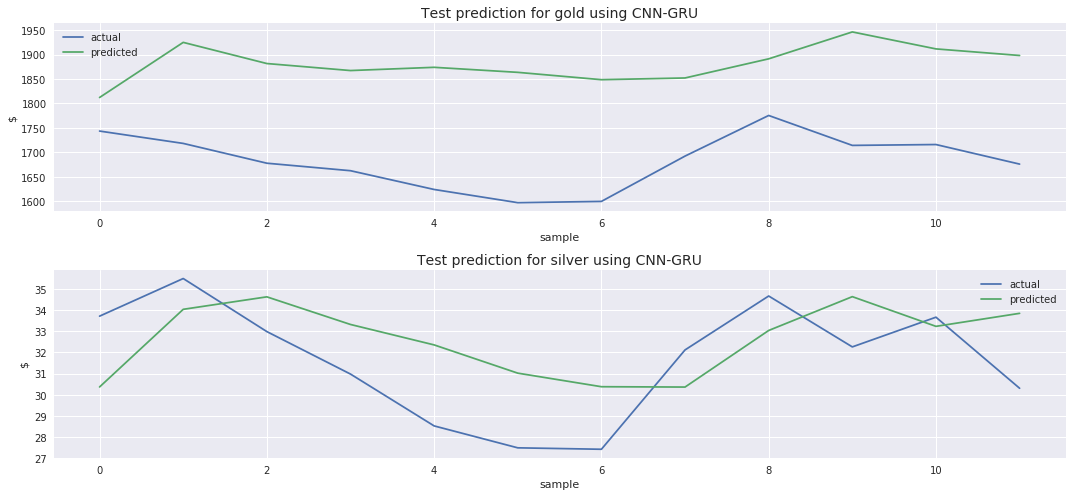

In [21]:
model = Sequential()
model.add(Conv1D(8, kernel_size=3, activation='relu', padding='same', strides=1, 
                 input_shape=(timesteps, features), kernel_initializer=xavier))

model.add(GRU(8, kernel_initializer=xavier, activation='relu'))

model.add(Dense(2, kernel_initializer=xavier))
model.summary()

# training
y_train_pred, y_test_pred, history = model_training(X_train, X_test, y_train, model, batch=2, name='cnngru-v7')

# evaluation
y_train_pred, y_test_pred = model_evaluation(y_train, y_test, y_train_pred, y_test_pred)

# plotting
plt.subplot(211)
plt.plot(np.exp(y_test.values[:, 0]), label='actual')
plt.plot(y_test_pred[:, 0], label='predicted')
plt.ylabel('$')
plt.xlabel('sample')
plt.title('Test prediction for gold using CNN-GRU', fontsize=14)
plt.legend()

plt.subplot(212)
plt.plot(np.exp(y_test.values[:, 1]), label='actual')
plt.plot(y_test_pred[:, 1], label='predicted')
plt.ylabel('$')
plt.xlabel('sample')
plt.title('Test prediction for silver using CNN-GRU', fontsize=14)
plt.legend()

plt.tight_layout()
plt.show()